# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from macrohet import dataio, tile, visualise
import btrack
print(btrack.__version__)
import os
import json 
from tqdm.auto import tqdm
import numpy as np
from natsort import natsorted
import glob
from skimage import io
import zarr
import re
import dask
# scale_factor = 2 #5.04
ndim = 2

0.6.1.dev127


In [3]:
os.getpid()

6883

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
expt_ID = 'ND0003'
location = 'SYNO' # 'NEMO' # 'SYNO'
base_dir = f'/mnt/{location}/macrohet_{location.lower()}/data/{expt_ID}/'
metadata_fn = os.path.join(base_dir, 'acquisition/Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_fn, assay_layout=True,)
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0301K1F1P1R1,Ok,r03c01f01p01-ch1sk1fk1fl1.tiff,3,1,1,1,0,1,1,...,0,0.135256499,0,2024-02-16T17:15:25.597+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
1,0301K1F1P1R2,Ok,r03c01f01p01-ch2sk1fk1fl1.tiff,3,1,1,1,0,2,1,...,0,0.135256499,0,2024-02-16T17:15:25.813+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
2,0301K1F1P2R1,Ok,r03c01f01p02-ch1sk1fk1fl1.tiff,3,1,1,2,0,1,1,...,2E-06,0.1352586,0,2024-02-16T17:15:26.157+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
3,0301K1F1P2R2,Ok,r03c01f01p02-ch2sk1fk1fl1.tiff,3,1,1,2,0,2,1,...,2E-06,0.1352586,0,2024-02-16T17:15:26.39+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
4,0301K1F1P3R1,Ok,r03c01f01p03-ch1sk1fk1fl1.tiff,3,1,1,3,0,1,1,...,4E-06,0.135260597,0,2024-02-16T17:15:26.733+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349267,0612K154F9P1R2,Ok,r06c12f09p01-ch2sk154fk1fl1.tiff,6,12,9,1,153,2,1,...,0,0.135008901,275402.773,2024-02-19T21:59:46.84+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349268,0612K154F9P2R1,Ok,r06c12f09p02-ch1sk154fk1fl1.tiff,6,12,9,2,153,1,1,...,2E-06,0.135010898,275402.773,2024-02-19T21:59:47.183+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349269,0612K154F9P2R2,Ok,r06c12f09p02-ch2sk154fk1fl1.tiff,6,12,9,2,153,2,1,...,2E-06,0.135010898,275402.773,2024-02-19T21:59:47.4+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349270,0612K154F9P3R1,Ok,r06c12f09p03-ch1sk154fk1fl1.tiff,6,12,9,3,153,1,1,...,4E-06,0.135012895,275402.773,2024-02-19T21:59:47.743+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."


In [4]:
image_dir = os.path.join(base_dir, 'acquisition/Images/')

In [5]:
image_fns = [os.path.join(image_dir, fn) for fn in metadata['URL']]

In [21]:
os.path.getsize(os.path.join(image_dir, 'r05c03f06p02-ch1sk154fk1fl1.tiff'))

9331456

In [33]:
from PIL import Image


def is_image_blank(image_path):
    with Image.open(image_path) as img:
        img_array = np.array(img)
        return np.all(img_array == 0)

# Pattern to match filenames with r05 and c03 to c09
pattern = re.compile(r'r05c0[3-9]')

blank_fns = []

for fn in tqdm(image_fns):
    if pattern.search(os.path.basename(fn)):
        if is_image_blank(fn):
            blank_fns.append(os.path.basename(fn))
            print(f"The image {os.path.basename(fn)} is blank")

# Optional: Print the list of blank filenames
print(f"Blank filenames: {blank_fns}")



  0%|          | 0/349272 [00:00<?, ?it/s]

The image r05c03f06p02-ch1sk154fk1fl1.tiff is blank
The image r05c03f06p02-ch2sk154fk1fl1.tiff is blank
The image r05c03f06p03-ch1sk154fk1fl1.tiff is blank
The image r05c03f06p03-ch2sk154fk1fl1.tiff is blank
The image r05c03f07p01-ch1sk154fk1fl1.tiff is blank
The image r05c03f07p01-ch2sk154fk1fl1.tiff is blank
The image r05c03f07p02-ch1sk154fk1fl1.tiff is blank
The image r05c03f07p02-ch2sk154fk1fl1.tiff is blank
The image r05c03f07p03-ch1sk154fk1fl1.tiff is blank
The image r05c03f07p03-ch2sk154fk1fl1.tiff is blank
The image r05c03f08p01-ch1sk154fk1fl1.tiff is blank
The image r05c03f08p01-ch2sk154fk1fl1.tiff is blank
The image r05c03f08p02-ch1sk154fk1fl1.tiff is blank
The image r05c03f08p02-ch2sk154fk1fl1.tiff is blank
The image r05c03f08p03-ch1sk154fk1fl1.tiff is blank
The image r05c03f08p03-ch2sk154fk1fl1.tiff is blank
The image r05c03f09p01-ch1sk154fk1fl1.tiff is blank
The image r05c03f09p01-ch2sk154fk1fl1.tiff is blank
The image r05c03f09p02-ch1sk154fk1fl1.tiff is blank
The image r0

In [34]:
len(blank_fns)

252

In [10]:
# Assuming blank_fns is already defined as a list of filenames
with open('missing_ND3_files.txt', 'r') as file:
    missing_files = [line.strip() for line in file]

# Compare the two lists
if sorted(blank_fns) == sorted(missing_files):
    print("The lists are the same.")
else:
    print("The lists are different.")


NameError: name 'blank_fns' is not defined

In [14]:
v = napari.Viewer()

v.add_image(io.imread(os.path.join(dir1, 'r05c03f06p02-ch1sk154fk1fl1.tiff')))
v.add_image(io.imread(os.path.join(dir2, 'r05c03f06p02-ch1sk154fk1fl1.tiff')))

<Image layer 'Image [1]' at 0x7eff800ed550>

In [6]:
import os
import time

dir1 = "/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/ND0003__2024-02-16T17_15_12-Measurement 1/Images"
dir2 = "/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images"

# Get the list of filenames in each directory
files_dir1 = set(os.listdir(dir1))
files_dir2 = set(os.listdir(dir2))

# Find files in dir1 that are not in dir2
missing_files = files_dir1 - files_dir2

# Print the missing files
for file in missing_files:
    print(file)


In [8]:
len(files_dir1), len(files_dir2)

(349273, 349273)

In [13]:
(missing_files)

['r05c03f06p02-ch1sk154fk1fl1.tiff',
 'r05c03f06p02-ch2sk154fk1fl1.tiff',
 'r05c03f06p03-ch1sk154fk1fl1.tiff',
 'r05c03f06p03-ch2sk154fk1fl1.tiff',
 'r05c03f07p01-ch1sk154fk1fl1.tiff',
 'r05c03f07p01-ch2sk154fk1fl1.tiff',
 'r05c03f07p02-ch1sk154fk1fl1.tiff',
 'r05c03f07p02-ch2sk154fk1fl1.tiff',
 'r05c03f07p03-ch1sk154fk1fl1.tiff',
 'r05c03f07p03-ch2sk154fk1fl1.tiff',
 'r05c03f08p01-ch1sk154fk1fl1.tiff',
 'r05c03f08p01-ch2sk154fk1fl1.tiff',
 'r05c03f08p02-ch1sk154fk1fl1.tiff',
 'r05c03f08p02-ch2sk154fk1fl1.tiff',
 'r05c03f08p03-ch1sk154fk1fl1.tiff',
 'r05c03f08p03-ch2sk154fk1fl1.tiff',
 'r05c03f09p01-ch1sk154fk1fl1.tiff',
 'r05c03f09p01-ch2sk154fk1fl1.tiff',
 'r05c03f09p02-ch1sk154fk1fl1.tiff',
 'r05c03f09p02-ch2sk154fk1fl1.tiff',
 'r05c03f09p03-ch1sk154fk1fl1.tiff',
 'r05c03f09p03-ch2sk154fk1fl1.tiff',
 'r05c04f01p01-ch1sk154fk1fl1.tiff',
 'r05c04f01p01-ch2sk154fk1fl1.tiff',
 'r05c04f01p02-ch1sk154fk1fl1.tiff',
 'r05c04f01p02-ch2sk154fk1fl1.tiff',
 'r05c04f01p03-ch1sk154fk1fl1.tiff',
 

# Moving correclty loaded images 

In [16]:
import os
import shutil

# Define directories
dir1 = "/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/ND0003__2024-02-16T17_15_12-Measurement 1/Images"
dir2 = "/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images"
blanks_dir = "/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/blanks"

# Create blanks directory if it doesn't exist
os.makedirs(blanks_dir, exist_ok=True)

for fn in tqdm(missing_files):
    src_file = os.path.join(dir1, fn)
    dest_file = os.path.join(dir2, fn)
    
    # Check if the file exists in dir2
    if os.path.exists(dest_file):
        # Move the existing file to blanks directory
        shutil.move(dest_file, os.path.join(blanks_dir, fn))
    
    # Copy the file from dir1 to dir2
    shutil.copy2(src_file, dest_file)


  0%|          | 0/252 [00:00<?, ?it/s]

# How many images should there be? 

In [9]:
len(metadata)

349272

In [ ]:

def count_files(directory):
    return len(os.listdir(directory))

dir1 = "/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/ND0003__2024-02-16T17_15_12-Measurement 1/Images"
sample_time = 10  # Sample time interval in seconds, you can change this value

previous_count = count_files(dir1)

while True:
    start_time = time.time()
    time.sleep(sample_time)
    count_start_time = time.time()
    current_count = count_files(dir1)
    count_end_time = time.time()
    
    counting_duration = count_end_time - count_start_time
    total_duration = sample_time + counting_duration
    
    files_added = current_count - previous_count
    files_per_minute = (files_added / total_duration) * 60
    
    print(f"Estimated files added per minute: {files_per_minute:.2f}")
    previous_count = current_count

In [65]:
current_count/len(metadata)

0.739841727936966

In [66]:
current_count = count_files(dir1)
current_count

304432

In [67]:
f'{(len(metadata) - current_count)/200/60:2f} hours to go'

'3.736667 hours to go'

In [68]:
print()

### Why are images not on the missing list appearing blank?

t 48 ch1 ch2 z1, z2, z3 all blank


In [39]:
glob.glob(os.path.join(image_dir, 'r05c03f*p*-ch1sk48fk1fl1.tiff'))

['/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f01p01-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f01p02-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f01p03-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f02p01-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f02p02-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f02p03-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f03p01-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f03p02-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f03p03-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f04p01-ch1sk48fk1fl1.tiff',
 '/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f04p02-ch1sk48fk1fl1.tiff',

In [51]:
img = io.imread('/mnt/SYNO/macrohet_syno/data/ND0003/acquisition/Images/r05c03f01p01-ch2sk4fk1fl1.tiff')

In [52]:
img

array([[122, 130, 134, ..., 116, 108, 102],
       [122, 131, 131, ..., 111, 114, 106],
       [128, 130, 131, ..., 106, 114, 120],
       ...,
       [611, 617, 610, ..., 112, 113, 117],
       [590, 584, 580, ..., 112, 114, 116],
       [571, 568, 586, ..., 115, 109, 117]], dtype=uint16)

# Is it my zarr loading that is problematic? the images themselves seem to be present 

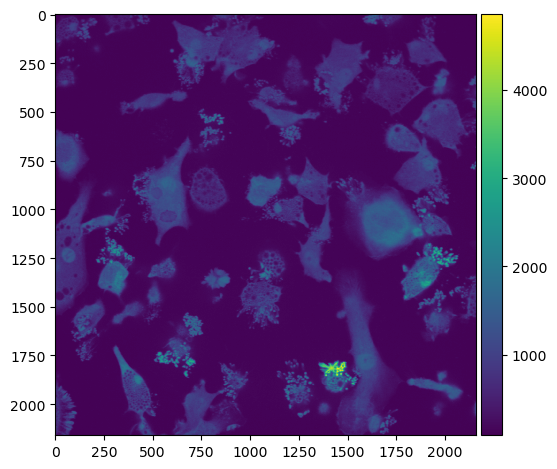

In [53]:
io.imshow(img)

# These files exist on the harddrive but not in the metadata

In [91]:
non_missing_fns

array(['r06c03f01p01-ch1sk1fk1fl1.tiff', 'r06c03f01p01-ch2sk1fk1fl1.tiff',
       'r06c03f01p02-ch1sk1fk1fl1.tiff', 'r06c03f01p02-ch2sk1fk1fl1.tiff',
       'r06c03f01p03-ch1sk1fk1fl1.tiff', 'r06c03f01p03-ch2sk1fk1fl1.tiff',
       'r06c03f02p01-ch1sk1fk1fl1.tiff', 'r06c03f02p01-ch2sk1fk1fl1.tiff',
       'r06c03f02p02-ch1sk1fk1fl1.tiff', 'r06c03f02p02-ch2sk1fk1fl1.tiff',
       'r06c03f02p03-ch1sk1fk1fl1.tiff', 'r06c03f02p03-ch2sk1fk1fl1.tiff',
       'r06c03f03p01-ch1sk1fk1fl1.tiff', 'r06c03f03p01-ch2sk1fk1fl1.tiff',
       'r06c03f03p02-ch1sk1fk1fl1.tiff', 'r06c03f03p02-ch2sk1fk1fl1.tiff',
       'r06c03f03p03-ch1sk1fk1fl1.tiff', 'r06c03f03p03-ch2sk1fk1fl1.tiff',
       'r06c03f04p01-ch1sk1fk1fl1.tiff', 'r06c03f04p01-ch2sk1fk1fl1.tiff',
       'r06c03f04p02-ch1sk1fk1fl1.tiff', 'r06c03f04p02-ch2sk1fk1fl1.tiff',
       'r06c03f04p03-ch1sk1fk1fl1.tiff', 'r06c03f04p03-ch2sk1fk1fl1.tiff',
       'r06c03f05p01-ch1sk1fk1fl1.tiff', 'r06c03f05p01-ch2sk1fk1fl1.tiff',
       'r06c03f05p02-ch1s

In [29]:
[os.path.getsize(os.path.join(image_dir, missing_fn)) for missing_fn in non_missing_fns]

[3864830,
 6082218,
 3908054,
 6009382,
 3913768,
 5930894,
 3867194,
 6895866,
 3900318,
 6793280,
 3904732,
 6643186,
 3929206,
 7156032,
 3974520,
 7111772,
 3980988,
 6998540,
 3915862,
 7078920,
 3960420,
 6988794,
 3957456,
 6865552,
 3925268,
 6695348,
 3965822,
 6580128,
 3957896,
 6479022,
 3898034,
 7005878,
 3939948,
 6913304,
 3950858,
 6813412,
 3929537,
 6824461,
 3967513,
 6744191,
 3976599,
 6631749,
 3858290,
 6550918,
 3909604,
 6478208,
 3913454,
 6378688,
 3901782,
 7172462,
 3951998,
 6995204,
 3955174,
 6831414]

In [28]:
[os.path.getsize(os.path.join(image_dir, missing_fn)) for missing_fn in missing_fns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [33]:
fns = metadata['URL'].values
all_missing_fns = [fn for fn in tqdm(fns) if os.path.getsize(os.path.join(image_dir, fn)) == 0]

  0%|          | 0/349272 [00:00<?, ?it/s]

In [35]:
len(all_missing_fns)

252

In [36]:
all_missing_fns

['r05c03f06p02-ch1sk154fk1fl1.tiff',
 'r05c03f06p02-ch2sk154fk1fl1.tiff',
 'r05c03f06p03-ch1sk154fk1fl1.tiff',
 'r05c03f06p03-ch2sk154fk1fl1.tiff',
 'r05c03f07p01-ch1sk154fk1fl1.tiff',
 'r05c03f07p01-ch2sk154fk1fl1.tiff',
 'r05c03f07p02-ch1sk154fk1fl1.tiff',
 'r05c03f07p02-ch2sk154fk1fl1.tiff',
 'r05c03f07p03-ch1sk154fk1fl1.tiff',
 'r05c03f07p03-ch2sk154fk1fl1.tiff',
 'r05c03f08p01-ch1sk154fk1fl1.tiff',
 'r05c03f08p01-ch2sk154fk1fl1.tiff',
 'r05c03f08p02-ch1sk154fk1fl1.tiff',
 'r05c03f08p02-ch2sk154fk1fl1.tiff',
 'r05c03f08p03-ch1sk154fk1fl1.tiff',
 'r05c03f08p03-ch2sk154fk1fl1.tiff',
 'r05c03f09p01-ch1sk154fk1fl1.tiff',
 'r05c03f09p01-ch2sk154fk1fl1.tiff',
 'r05c03f09p02-ch1sk154fk1fl1.tiff',
 'r05c03f09p02-ch2sk154fk1fl1.tiff',
 'r05c03f09p03-ch1sk154fk1fl1.tiff',
 'r05c03f09p03-ch2sk154fk1fl1.tiff',
 'r05c04f01p01-ch1sk154fk1fl1.tiff',
 'r05c04f01p01-ch2sk154fk1fl1.tiff',
 'r05c04f01p02-ch1sk154fk1fl1.tiff',
 'r05c04f01p02-ch2sk154fk1fl1.tiff',
 'r05c04f01p03-ch1sk154fk1fl1.tiff',
 

In [73]:
metadata['ImageResolutionX'].iloc[0]

'1.4949402023919043E-07'

In [55]:
len(all_missing_fns)

252

In [42]:
os.path.exists(os.path.join(image_dir, all_missing_fns[0]))

True

In [46]:
still_missing_fns = [fn for fn in all_missing_fns if os.path.exists(os.path.join(image_dir, fn)) and os.path.getsize(os.path.join(image_dir, fn)) == 0]

In [47]:
len(still_missing_fns)

252

In [68]:
with open('missing_ND3_files.txt', 'w') as file:
    for item in still_missing_fns:
        file.write(f"{item}\n")


In [57]:
filtered_metadata = metadata[metadata['URL'].isin(all_missing_fns)]


In [62]:
filtered_metadata['TimepointID'].unique()

array(['153'], dtype=object)

In [61]:
filtered_metadata['Row'].unique(),filtered_metadata['Col'].unique()

(array(['5'], dtype=object),
 array(['3', '4', '5', '6', '7', '8'], dtype=object))

In [63]:
filtered_metadata['PlaneID'].unique()

array(['2', '3', '1'], dtype=object)

In [65]:
filtered_metadata['ChannelID'].unique()

array(['1', '2'], dtype=object)

In [67]:
filtered_metadata['FieldID'].unique()

array(['6', '7', '8', '9', '1', '2', '3', '4', '5'], dtype=object)

In [50]:
from skimage import io

In [52]:
test_frame = io.imread(os.path.join(image_dir, metadata['URL'].iloc[0]))

In [69]:
blank_image = np.zeros_like(test_frame)

In [71]:
for fn in tqdm(all_missing_fns):
    full_path = os.path.join(image_dir, fn)
    if os.path.exists(full_path) and os.path.getsize(full_path) == 0:
        io.imsave(full_path, blank_image)

  0%|          | 0/252 [00:00<?, ?it/s]

/tmp/ipykernel_748641/2680398995.py:4: UserWarning: /mnt/SYNO/macrohet_syno/ND0003/acquisition/Images/r05c03f06p02-ch1sk154fk1fl1.tiff is a low contrast image
  io.imsave(full_path, blank_image)
/tmp/ipykernel_748641/2680398995.py:4: UserWarning: /mnt/SYNO/macrohet_syno/ND0003/acquisition/Images/r05c03f06p02-ch2sk154fk1fl1.tiff is a low contrast image
  io.imsave(full_path, blank_image)
/tmp/ipykernel_748641/2680398995.py:4: UserWarning: /mnt/SYNO/macrohet_syno/ND0003/acquisition/Images/r05c03f06p03-ch1sk154fk1fl1.tiff is a low contrast image
  io.imsave(full_path, blank_image)
/tmp/ipykernel_748641/2680398995.py:4: UserWarning: /mnt/SYNO/macrohet_syno/ND0003/acquisition/Images/r05c03f06p03-ch2sk154fk1fl1.tiff is a low contrast image
  io.imsave(full_path, blank_image)
/tmp/ipykernel_748641/2680398995.py:4: UserWarning: /mnt/SYNO/macrohet_syno/ND0003/acquisition/Images/r05c03f07p01-ch1sk154fk1fl1.tiff is a low contrast image
  io.imsave(full_path, blank_image)
/tmp/ipykernel_748641/268

In [49]:
(os.path.join(image_dir, metadata['URL'].iloc[0]))

3867329

# PROOF

In [103]:
actually_missing_fns[0] in metadata['URL'].values

False

In [104]:
non_missing_fns[0] in metadata['URL'].values

True

In [99]:
os.path.exists(os.path.join(image_dir, actually_missing_fns[0]))

True

# Checking for anymore

In [109]:
t_list = []
for t in range(1,151):
    for fn in non_missing_fns:
        fn = fn.replace('sk1', f'sk{t}')
        if not fn in metadata['URL'].values:
            if t not in t_list:
                t_list.append(t)
                print(t) 

15
45
69
90
98
131
148


# Fixing missing metadata

In [135]:
metadata.keys()


Index(['id', 'State', 'URL', 'Row', 'Col', 'FieldID', 'PlaneID', 'TimepointID',
       'ChannelID', 'FlimID', 'ChannelName', 'ImageType', 'AcquisitionType',
       'IlluminationType', 'ChannelType', 'ImageResolutionX',
       'ImageResolutionY', 'ImageSizeX', 'ImageSizeY', 'BinningX', 'BinningY',
       'MaxIntensity', 'CameraType', 'PositionX', 'PositionY', 'PositionZ',
       'AbsPositionZ', 'MeasurementTimeOffset', 'AbsTime',
       'MainExcitationWavelength', 'MainEmissionWavelength',
       'ObjectiveMagnification', 'ObjectiveNA', 'ExposureTime',
       'OrientationMatrix'],
      dtype='object')

In [161]:
float(metadata['ImageResolutionX'].iloc[0])/

1.4949402023919043e-07

In [136]:
metadata

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


In [147]:
url = actually_missing_fns[0]

In [165]:
metadata[(metadata['Row'] == str(row)) & 
         (metadata['Col'] == str(column)) &
         (metadata['TimepointID'] == str(1))]['URL'].values

array(['r06c03f01p01-ch1sk2fk1fl1.tiff', 'r06c03f01p01-ch2sk2fk1fl1.tiff',
       'r06c03f01p02-ch1sk2fk1fl1.tiff', 'r06c03f01p02-ch2sk2fk1fl1.tiff',
       'r06c03f01p03-ch1sk2fk1fl1.tiff', 'r06c03f01p03-ch2sk2fk1fl1.tiff',
       'r06c03f02p01-ch1sk2fk1fl1.tiff', 'r06c03f02p01-ch2sk2fk1fl1.tiff',
       'r06c03f02p02-ch1sk2fk1fl1.tiff', 'r06c03f02p02-ch2sk2fk1fl1.tiff',
       'r06c03f02p03-ch1sk2fk1fl1.tiff', 'r06c03f02p03-ch2sk2fk1fl1.tiff',
       'r06c03f03p01-ch1sk2fk1fl1.tiff', 'r06c03f03p01-ch2sk2fk1fl1.tiff',
       'r06c03f03p02-ch1sk2fk1fl1.tiff', 'r06c03f03p02-ch2sk2fk1fl1.tiff',
       'r06c03f03p03-ch1sk2fk1fl1.tiff', 'r06c03f03p03-ch2sk2fk1fl1.tiff',
       'r06c03f04p01-ch1sk2fk1fl1.tiff', 'r06c03f04p01-ch2sk2fk1fl1.tiff',
       'r06c03f04p02-ch1sk2fk1fl1.tiff', 'r06c03f04p02-ch2sk2fk1fl1.tiff',
       'r06c03f04p03-ch1sk2fk1fl1.tiff', 'r06c03f04p03-ch2sk2fk1fl1.tiff',
       'r06c03f05p01-ch1sk2fk1fl1.tiff', 'r06c03f05p01-ch2sk2fk1fl1.tiff',
       'r06c03f05p02-ch1s

In [155]:
new_url = re.sub(r'sk\d+', 'sk2', url)
row = metadata[metadata['URL'] == new_url]


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
4638,0603K2F1P1R1,Ok,r06c03f01p01-ch1sk2fk1fl1.tiff,6,3,1,1,1,1,1,...,-2E-06,0.135386199,1799.683,2023-11-30T17:50:23.653+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


In [176]:
reference_row.keys()

Index(['id', 'State', 'URL', 'Row', 'Col', 'FieldID', 'PlaneID', 'TimepointID',
       'ChannelID', 'FlimID', 'ChannelName', 'ImageType', 'AcquisitionType',
       'IlluminationType', 'ChannelType', 'ImageResolutionX',
       'ImageResolutionY', 'ImageSizeX', 'ImageSizeY', 'BinningX', 'BinningY',
       'MaxIntensity', 'CameraType', 'PositionX', 'PositionY', 'PositionZ',
       'AbsPositionZ', 'MeasurementTimeOffset', 'AbsTime',
       'MainExcitationWavelength', 'MainEmissionWavelength',
       'ObjectiveMagnification', 'ObjectiveNA', 'ExposureTime',
       'OrientationMatrix'],
      dtype='object')

In [193]:
float(reference_row['MeasurementTimeOffset'].iloc[0])

1799.683

In [203]:

new_rows = []  # To collect new rows to be added

for t in tqdm(t_list):
    for example_fn in tqdm(metadata[(metadata['Row'] == str(row)) & 
                                     (metadata['Col'] == str(column)) &
                                     (metadata['TimepointID'] == str(1))]['URL'].values, leave=False):
        reference_row = metadata[metadata['URL'] == example_fn].iloc[0]  # Use .iloc[0] to get a Series
        
        if not reference_row.empty:
            # Convert the Series to a dict and modify as necessary
            new_row = reference_row.to_dict()
            new_row['URL'] = re.sub(r'sk\d+', f'sk{t}', example_fn)
            new_row['id'] = reference_row['id'].replace('K2', f'K{t}')
            new_row['State'] = 'augmented metadata'
            new_row['TimepointID'] = str(t-1)
            new_row['MeasurementTimeOffset'] = str((t-1) * float(reference_row['MeasurementTimeOffset']))
            new_row['AbsTime'] = 'Unknown'  # Make sure to match your column name's case exactly
            new_rows.append(new_row)

# Convert new rows list to DataFrame and append to the original metadata DataFrame
if new_rows:
    new_rows_df = pd.DataFrame(new_rows)
    metadata = pd.concat([metadata, new_rows_df], ignore_index=True)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [205]:
metadata[metadata['URL'] == actually_missing_fns[0]]

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
388620,0603K15F1P1R1,augmented metadata,r06c03f01p01-ch1sk15fk1fl1.tiff,6,3,1,1,14,1,1,...,-2E-06,0.135386199,25195.561999999998,Unknown,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


In [207]:
metadata.to_xml('test.xml')

In [211]:
metadata_fn

'/mnt/SYNO/macrohet_syno/ND0002/acquisition/Assaylayout/ND0001AssayLayout.xml'

In [212]:
metadata.to_pickle('/mnt/SYNO/macrohet_syno/ND0002/acquisition/ND0002_fixed_metadata.pkl')

In [209]:
test = dataio.read_harmony_metadata('test.xml')  

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!


In [210]:
test

""


In [139]:
metadata[(metadata['Row'] == str(row)) & 
         (metadata['Col'] == str(column)) &
         (metadata['TimepointID'] == str(14))].iloc[0]

id                                                              0603K15F2P1R1
State                                                                      Ok
URL                                           r06c03f02p01-ch1sk15fk1fl1.tiff
Row                                                                         6
Col                                                                         3
FieldID                                                                     2
PlaneID                                                                     1
TimepointID                                                                14
ChannelID                                                                   1
FlimID                                                                      1
ChannelName                                                         E2Crimson
ImageType                                                              Signal
AcquisitionType                                                N

In [125]:
import pandas as pd

In [126]:

# Template for the new rows based on observed filename structure and metadata keys
new_rows = []

for filename in actually_missing_fns:
    # Parse filename using regular expression
    match = re.match(r"r(\d+)c(\d+)f(\d+)p(\d+)-ch(\d+)sk(\d+)", filename)
    if match:
        row, col, field_id, plane_id, channel_id, timepoint_id = match.groups()
        new_row = {
            'Row': int(row),
            'Col': int(col),
            'FieldID': int(field_id),
            'PlaneID': int(plane_id),
            'TimepointID': int(timepoint_id),
            'ChannelID': int(channel_id),
            'URL': filename,  # Assuming the filename itself is the URL or modify accordingly
            # Fill in other columns based on patterns or defaults. For example:
            'State': 'missing',  # Indicate these rows are added for missing data
            # Add other necessary columns based on your metadata structure
        }
        new_rows.append(new_row)

# Convert the list of dictionaries to a DataFrame
new_entries_df = pd.DataFrame(new_rows)

In [127]:
new_entries_df

,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,URL,State
0,6,3,1,1,15,1,r06c03f01p01-ch1sk15fk1fl1.tiff,missing
1,6,3,1,1,15,2,r06c03f01p01-ch2sk15fk1fl1.tiff,missing
2,6,3,1,2,15,1,r06c03f01p02-ch1sk15fk1fl1.tiff,missing
3,6,3,1,2,15,2,r06c03f01p02-ch2sk15fk1fl1.tiff,missing
4,6,3,1,3,15,1,r06c03f01p03-ch1sk15fk1fl1.tiff,missing
5,6,3,1,3,15,2,r06c03f01p03-ch2sk15fk1fl1.tiff,missing
6,6,3,3,1,15,1,r06c03f03p01-ch1sk15fk1fl1.tiff,missing
7,6,3,3,1,15,2,r06c03f03p01-ch2sk15fk1fl1.tiff,missing
8,6,3,3,2,15,1,r06c03f03p02-ch1sk15fk1fl1.tiff,missing
9,6,3,3,2,15,2,r06c03f03p02-ch2sk15fk1fl1.tiff,missing


In [ ]:
dataio.read_harmony_metadata(metadata_fn)  

In [ ]:
data = assay_layout.loc[acq_ID]
        
zarr_group = zarr.open(zarr_fn, mode='w')
acq_metadata = data.to_dict()
acq_metadata['Acquisition ID'] = acq_ID
acq_metadata['Experiment ID'] = expt_ID
acq_metadata['Dimensionality'] = 'TCZYX'
rechunked_images = dask_images.rechunk((1, 1, 1, 6048, 6048))
print('Loading image')
# rechunked_images = rechunked_images
# Save Dask array to Zarr
print('Saving zarr')
dask.array.to_zarr(rechunked_images, zarr_fn, component='images')

# Store metadata in the Zarr group's attributes
zarr_group.attrs['metadata'] = acq_metadata

## Quick check that it worked

In [83]:
zarr_gp = zarr.open(zarr_fn)
zarr_gp.attrs['me']

In [77]:
dask_images = tile.compile_mosaic(image_dir, 
                                     metadata, 
                                     row, column, 
                                     set_channel=1,set_plane=1,set_time=1
                                    ).compute()
    
data = assay_layout.loc[acq_ID]

zarr_group = zarr.open(zarr_fn, mode='w')
acq_metadata = data.to_dict()
acq_metadata['Acquisition ID'] = acq_ID
acq_metadata['Experiment ID'] = expt_ID
acq_metadata['Dimensionality'] = 'TCZYX'
rechunked_images = dask_images.rechunk((1, 1, 1, 6048, 6048))
print('Loading image')
# rechunked_images = rechunked_images
# Save Dask array to Zarr
print('Saving zarr')
dask.array.to_zarr(rechunked_images, zarr_fn, component='images')

# Store metadata in the Zarr group's attributes
zarr_group.attrs['metadata'] = acq_metadata

Loading image
Saving zarr


In [68]:
zarr_group.attrs['metadata']

{'Strain': 'WT',
 'Compound': 'PZA',
 'Concentration': '60',
 'ConcentrationEC': 'EC50',
 'Acquisition ID': (3, 6),
 'Experiment ID': 'PS0000',
 'Dimensionality': 'TCZYX'}

In [78]:
zarr_group_2 = zarr.open(zarr_fn, mode='r')

In [79]:
zarr_group_2.images

<zarr.core.Array '/images' (1, 1, 1, 6048, 6048) uint16 read-only>

In [76]:
zarr_group_2.attrs['metadata']

{'Acquisition ID': [3, 6],
 'Compound': 'PZA',
 'Concentration': '60',
 'ConcentrationEC': 'EC50',
 'Dimensionality': 'TCZYX',
 'Experiment ID': 'PS0000',
 'Strain': 'WT'}

In [123]:
missing_files = []
for fn in tqdm(subset_df['URL']):
    if not os.path.exists(os.path.join(image_dir, fn)):
        missing_files.append(fn)

  0%|          | 0/7950 [00:00<?, ?it/s]

### testing with compression

In [82]:
# Loop through assay_layout
for (row, column), data in tqdm(assay_layout.iterrows(), total=len(assay_layout)):

    if (row, column) == (3,4):
        continue

    # First set of images without compression
    output_fn = f'/mnt/NEMO/home/users/dayn/macrohet_nemo/{expt_ID}/acquisition/zarr/{row, column}.zarr'
    os.makedirs(os.path.dirname(output_fn), exist_ok=True)    
    # if not os.path.exists(output_fn):

    images = tile.compile_mosaic(image_dir, metadata, row, column).compute()

    store = zarr.DirectoryStore(output_fn)

    # rechunk for saving 
    # images = images.rechunk((150, 2, 3, 2016, 2016)).
    images = images.rechunk((150, 2, 3, 1000, 1000))  # Adjust the chunk sizes as needed

    # Save Dask array to Zarr without compression
    images.to_zarr(store, overwrite=True, group='images', compute=True, codec=zarr.Blosc(cname='lz4', clevel=5))
    
    # images.to_zarr(store, overwrite=True, group='images', compute=True)

    zarr_group = zarr.open(store)
    zarr_group.attrs['Row'] = row
    zarr_group.attrs['Column'] = column
    for key, i in zip(data.keys(), data):
        zarr_group.attrs[key] = i

        # # Second set of images with Blosc-LZ4-Bitshuffle-8 compression
        # output_fn_compressed = f'/mnt/NEMO/home/users/dayn/macrohet_nemo/{expt_ID}/acquisition/zarr/compressed/{row, column}_compressed.zarr'
        # # make dirs
        # os.makedirs(os.path.dirname(output_fn_compressed), exist_ok=True)    
        
        # store_compressed = zarr.DirectoryStore(output_fn_compressed)
    
        # # Specify Blosc-LZ4-Bitshuffle-8 compression options
        # compressor = zarr.Blosc(cname='blosclz', clevel=5, shuffle=zarr.Blosc.BITSHUFFLE)
        
        # # Save Dask array to Zarr with Blosc-LZ4-Bitshuffle-8 compression
        # images.to_zarr(store_compressed, overwrite=True, group='images', compressor=compressor,)# compute=True,)
    
        # zarr_group_compressed = zarr.open(store_compressed)
        # zarr_group_compressed.attrs['Row'] = row
        # zarr_group_compressed.attrs['Column'] = column
        # for key, i in zip(data.keys(), data):
        #     zarr_group_compressed.attrs[key] = i

  0%|          | 0/42 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'group'
  warn("ignoring keyword argument %r" % k)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'codec'
  warn("ignoring keyword argument %r" % k)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'group'
  warn("ignoring keyword argument %r" % k)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'codec'
  warn("ignoring keyword argument %r" % k)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'group'
  warn("ignoring keyword argument %r" % k)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argu

ValueError: total size of new array must be unchanged